# Отток клиентов 

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.


Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.


Построим модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверим F1-меру на тестовой выборке.


Дополнительно будем измерять AUC-ROC и сравнивать её значение с F1-мерой.

## Описание данных

Признаки


* RowNumber — индекс строки в данных

*    CustomerId — уникальный идентификатор клиента
*    Surname — фамилия
*    CreditScore — кредитный рейтинг
*    Geography — страна проживания
*    Gender — пол
*    Age — возраст
*    Tenure — количество недвижимости у клиента
*    Balance — баланс на счёте
*    NumOfProducts — количество продуктов банка, используемых клиентом
*    HasCrCard — наличие кредитной карты
*    IsActiveMember — активность клиента
*    EstimatedSalary — предполагаемая зарплата


Целевой признак


*    Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
churn.head(20)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Проверим наличие дубликатов
churn.duplicated().sum()

0

In [7]:
# Переведем название колонок в нижний регистр
churn.columns = churn.columns.str.lower()

In [8]:
# Посмотрим из каких стран клиенты
churn['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [9]:
#Предположим, что пропуски признака tenure означают отсутствие недвижимости, 
#поэтому заменим их на 0.

churn['tenure'].fillna(0, inplace=True)

Удалим признаки, которые не влияют на уход клиента:

* RowNumber индекс строки в данных;


* CustomerId уникальный идентификатор;


* Surname фамилия клиента.

In [10]:
churn_drop = churn.drop(columns=['rownumber', 'customerid', 'surname'])

In [11]:
#Переведем категориальные признаки в численные
churn_ohe = pd.get_dummies(churn_drop, drop_first=True)

In [12]:
churn_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


В данных присутствуют признаки, значения которых сильно разбросаны, например, age, tenure, estimatedsalary, balance, creditscore. Чтобы алгоритм не решил, что один признак важнее другого, приведем их к одному масштабу, стандартизируем данные.

In [13]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(churn_ohe[numeric])

churn_ohe[numeric] = scaler.transform(churn_ohe[numeric])

In [14]:
# Посмотрим на корреляцию признаков
churn_ohe.corr()['exited'].sort_values()

isactivemember      -0.156128
gender_Male         -0.106512
geography_Spain     -0.052667
numofproducts       -0.047820
creditscore         -0.027094
tenure              -0.013319
hascrcard           -0.007138
estimatedsalary      0.012097
balance              0.118533
geography_Germany    0.173488
age                  0.285323
exited               1.000000
Name: exited, dtype: float64

In [15]:
churn_ohe.corr()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
creditscore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,0.011225,-0.013319,0.001676,-0.000745,0.014889
balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
numofproducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
hascrcard,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
isactivemember,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
estimatedsalary,-0.001384,-0.007201,0.011225,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
geography_Germany,0.005538,0.046897,0.001676,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


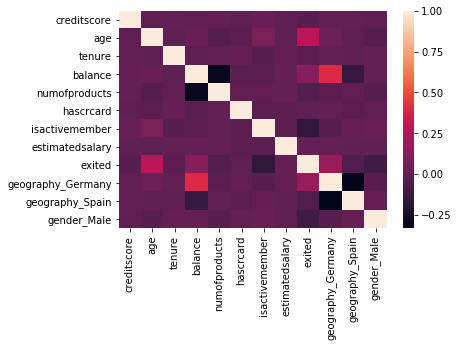

In [16]:
sns.heatmap(churn_ohe.corr());

  * Наблюдается отрицательная зависимость между колличеством продуктов и балансом. Причина не выявлена.
  * Наблюдается положительная зависимость между тем, что клиент из Германии и его балансом. Можно объяснить это бОльшим доходом у населения Германии.
  * Наблюдается отрицательная корреляция между тем, что клиент из Испании и его балансом. Причина - доходы меньше, чем в Германии и Франции.
  * Отрицательная корреляция между активностью клиента и тем, что он ушел. Чем меньше активность клиента, тем точнее мы можем определить, что он уйдет.
  * Прямая зависимость между уходом и возрастом. Прична не выявлена, обычно, люди в возрасте менее охотно меняют банки.

In [17]:
churn_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,-0.817441,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.138838,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.110941,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.138838,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-0.817441,0.785728,1,1,1,-0.365276,0,0,1,0


### Разобьём данные на выборки

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1 (60% : 20% : 20%).

In [18]:
churn_train, churn_valid =  train_test_split(churn_ohe, test_size=0.4, random_state=12345)

In [19]:
churn_train.shape

(6000, 12)

In [20]:
churn_valid.shape

(4000, 12)

In [21]:
churn_valid, churn_test =  train_test_split(
    churn_valid, test_size=0.5, random_state=12345
    )

In [22]:
churn_valid.shape

(2000, 12)

In [23]:
churn_test.shape

(2000, 12)

In [24]:
features_train = churn_train.drop(['exited'], axis=1)
target_train = churn_train['exited'] 

In [25]:
features_valid = churn_valid.drop(['exited'], axis=1)
target_valid = churn_valid['exited'] 

In [26]:
features_test = churn_test.drop(['exited'], axis=1)
target_test = churn_test['exited'] 

In [27]:
churn_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
7479,-0.864254,-0.373958,1.110941,1.228508,1,1,0,-0.198777,0,0,1,1
3411,0.625682,-0.183251,1.110941,0.599639,1,0,0,-0.345607,0,0,0,0
6027,2.063884,0.484225,-0.496044,1.024257,2,0,1,1.498850,0,1,0,1
1247,-1.433326,-1.422847,0.468147,-1.225848,2,1,0,-1.085698,0,0,0,1
3716,0.149730,-1.136786,-0.817441,1.137125,1,0,0,1.520109,0,1,0,0


### Вывод

Датасет состоит из 10 000 объектов и 14 признаков. Для обучения модели нам не потребуются:

* RowNumber индекс строки в данных;
* CustomerId уникальный идентификатор;
* Surname фамилия клиента.

Целевой признак - Exited, т.е. модель, которую требуется построить, будет предсказывать значение 1, если клиент уйдет, или 0, если нет.

Дубликаты не обнаружены

В датасете представлены клиенты из трех стран: Франции ~50%, Германии ~25% и Испании ~25%.


Признак Tenure (количество недвижимости у клиента) содержит 909 пропусков. Предположим, что эти пропуски означают отсутствие недвижимости, поэтому пропуски были заменены на 0.


Категориальные признаки переведены в численные с помощью техники прямого кодирования (One-Hot Encoding) и, чтобы не угодить в ловушку фиктивных признаков, первые (уже переведенные в численные) столбцы из каждого категории были удалены.


Из-за разброса в численных значениях признаков 'creditscore', 'age', 'tenure', 'balance', 'estimatedsalary', была произведена стандартизация данных.


Исходя из задания, данные были разделены на три выборки в соотношении 3:1:1. 


Определены признаки и целевой признак для каждой из выборок.


# 2. Исследование задачи

Целевой признак (ответ) бывает категориальным и количественным. Если он категориальный, то решается задача классификации; если количественный — регрессии. Мы имеем две категории целевого признака exited:

1 - клиент ушёл


0 - клиент не ушёл


Значит мы решаем задачу классификации с помощью моделей DecisionTreeClassifier, RandomForestClassifier и LogisticRegression.

Классы несбалансированны, когда их соотношение далеко от 1:1. Баланс классов наблюдается, если их количество примерно равно.

Прверим какой баланс классов в нашем случае.

0    0.7963
1    0.2037
Name: exited, dtype: float64


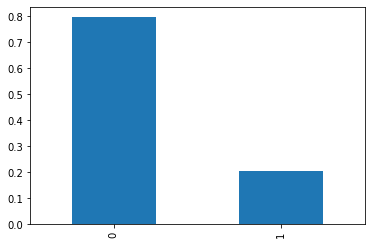

In [28]:
class_frequency = churn['exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
print(class_frequency)
plt.show()

График показывает, что наши классы несбалансированы. Мы имеем 20% ушедших клиентов и 80% текущих клиентов.

Обучим модель без учёта дисбаланса

Насколько успешна модель будем оценивать через 


* метрику F1 - среднее гармоническое полноты и точности, единица в F1 означает, что соотношение полноты и точности равно 1:1;


* accuracy - отношение числа правильных ответов к размеру тестовой выборки, чем ближе точность к 1, тем лучше;


* AUC-ROC выявляет, как сильно наша модель отличается от случайной, считает площадь под ROC-кривой. Принимает значения от 0 до 1. AUC-ROC случайной модели равна 0.5.

**Обучение модели DecisionTreeClassifier**

In [29]:
dec_tree = DecisionTreeClassifier()

Попробуем с помощью GridSearch найти наиболее подходящие параметры для модели.

Выберем параметры для настройки модели.

In [30]:
dec_tree.get_params(deep=True)

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

Остановимся на параметрах:

max_depth - максимальная глубина дерева;

max_features - максимальное количество признаков, которые следует учитывать при поиске лучшего разделения;

min_samples_split - минимальное количество примеров для разделения. Этот гиперпараметр запрещает создавать узлы, в которые попадает слишком мало объектов обучающей выборки.

random_state = '12345' - зафиксируем псевдослучайность для алгоритма обучения.

In [31]:
dec_tree_params = {'max_depth': [5, 6, 8, 10, 12],
               'max_features': [5, 7, 9, 10, 11], 
               'min_samples_split' : [15, 20, 30, 45],
               'random_state' : [12345]
                }

In [32]:
dec_tree_grid = GridSearchCV(dec_tree, dec_tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [33]:
dec_tree_grid.fit(features_train, target_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 6, 8, 10, 12],
                         'max_features': [5, 7, 9, 10, 11],
                     

In [34]:
dec_tree_grid.best_params_

{'max_depth': 8,
 'max_features': 7,
 'min_samples_split': 45,
 'random_state': 12345}

In [35]:
dec_tree_grid.best_score_

0.8606666666666667

In [36]:
model_dec_tree_class = DecisionTreeClassifier(random_state=12345,
                                              max_depth=8,
                                              max_features = 7,
                                              min_samples_split = 45)

model_dec_tree_class.fit(features_train, target_train)

predictions_dec_tree_class = model_dec_tree_class.predict(features_valid)

accuracy_dec_tree_class = accuracy_score(target_valid, predictions_dec_tree_class)

print('Accuracy =', accuracy_dec_tree_class)

print('F1 =', f1_score(target_valid, predictions_dec_tree_class))

probabilities_valid = model_dec_tree_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.853
F1 = 0.5637982195845697
AUC-ROC = 0.8261724302711726


**Обучение модели RandomForestClassifier**

In [37]:
rand_forest = RandomForestClassifier()

In [38]:
rand_forest.get_params(deep=True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [39]:
rand_forest_params = {'max_depth': [5, 8, 10, 11],
               'max_features': [7, 9, 10, 11], 
               'min_samples_split' : [15, 45],
               'n_estimators' : [20,  60, 80],
               'random_state' : [12345]
                }

Остановимся на параметрах:

max_depth - максимальная глубина дерева;

max_features - максимальное количество признаков, которые следует учитывать при поиске лучшего разделения;

min_samples_split - минимальное количество примеров для разделения. Этот гиперпараметр запрещает создавать узлы, в которые попадает слишком мало объектов обучающей выборки.

n_estimators - число деревьев;

random_state = '12345' - зафиксируем псевдослучайность для алгоритма обучения.

In [40]:
rand_forest_grid = GridSearchCV(rand_forest, rand_forest_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [41]:
rand_forest_grid.fit(features_train, target_train)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [42]:
rand_forest_grid.best_params_

{'max_depth': 10,
 'max_features': 7,
 'min_samples_split': 45,
 'n_estimators': 80,
 'random_state': 12345}

In [43]:
rand_forest_grid.best_score_

0.8683333333333333

Обучим модель с предложенными параметрами.

In [44]:
model_random_forest_class = RandomForestClassifier(random_state=12345,
                                                    max_depth=10,
                                                    min_samples_split = 45,
                                                    n_estimators = 80,
                                                    max_features = 9,
                                                   )

model_random_forest_class.fit(features_train, target_train)
  
predictions_random_forest_class = model_random_forest_class.predict(features_valid)

accuracy_random_forest_class = accuracy_score(target_valid, predictions_random_forest_class)

print('Accuracy =', accuracy_random_forest_class)

print('F1 =', f1_score(target_valid, predictions_random_forest_class))

probabilities_valid = model_random_forest_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.863
F1 = 0.5898203592814371
AUC-ROC = 0.8514425141695752


**Обучение модели LogisticRegression**

In [45]:
model_log_reg = LogisticRegression(random_state=12345)

In [46]:
model_log_reg.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 12345,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Остановимся на параметрах:

* 'C' - константа регуляризации
* 'solver' - алгоритм для оптимизации
* 'class_weight' - определение веса классов
* 'penalty' - тип регуляризатора
* 'random_state' - зафиксируем псевдослучайность для алгоритма обучения.

In [47]:
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 20],
    'solver': ['liblinear'], 
    'penalty': ['l1', 'l2'],
    'random_state': [12345]
}
log_reg_grid = GridSearchCV(model_log_reg, log_reg_params, cv=5, n_jobs=-1, verbose=True)
log_reg_grid.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=12345, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 20], 'penalty': ['l1', 'l2'],
                         'random_state': [12345], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [48]:
log_reg_grid.best_score_,  log_reg_grid.best_params_

(0.8176666666666667,
 {'C': 0.1, 'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'})

In [49]:
model_log_reg = LogisticRegression(random_state=12345, 
                                  C= 0.1, 
                                  penalty= 'l1', 
                                  solver='liblinear')
model_log_reg.fit(features_train, target_train)

predictions_log_reg = model_log_reg.predict(features_valid)

accuracy_log_reg = accuracy_score(target_valid, predictions_log_reg)

print('Accuracy =', accuracy_log_reg)
print("F1:", f1_score(target_valid, predictions_log_reg))

probabilities_valid = model_log_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.8055
F1: 0.32111692844677137
AUC-ROC = 0.7599973384789407


### Вывод

Среднее гармоническое полноты и точности больше всех в модели RandomForestClassifier - 0.5898, почти нужное нам 0.59. Точность у всех моделей больше 80 %. AUC-ROC у всех больше 75%.

Осталось довести F1 до 0.59.

# 3. Борьба с дисбалансом

### Взвешивание классов

Алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. Если важно указать, что какие-то объекты важнее, их классу присваивается вес.

Если указать class_weight='balanced' при обучении модели, алгоритм посчитает, во сколько раз класс «0» встречается чаще класса «1». 

**DecisionTreeClassifier**

In [50]:
model_dec_tree_class = DecisionTreeClassifier(random_state=12345,
                                              max_depth=8,
                                              max_features = 7,
                                              min_samples_split = 45,
                                              class_weight='balanced')

model_dec_tree_class.fit(features_train, target_train)

predictions_dec_tree_class = model_dec_tree_class.predict(features_valid)

accuracy_dec_tree_class = accuracy_score(target_valid, predictions_dec_tree_class)

print('Accuracy =', accuracy_dec_tree_class)

print('F1 =', f1_score(target_valid, predictions_dec_tree_class))

probabilities_valid = model_dec_tree_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.7765
F1 = 0.5779036827195467
AUC-ROC = 0.8123725948015655


**RandomForestClassifier**

In [51]:
model_random_forest_class = RandomForestClassifier(random_state=12345,
                                                    max_depth=10,
                                                    min_samples_split = 45,
                                                    n_estimators = 80,
                                                    max_features = 9,
                                                    class_weight='balanced'
                                                   )

model_random_forest_class.fit(features_train, target_train)
  
predictions_random_forest_class = model_random_forest_class.predict(features_valid)

accuracy_random_forest_class = accuracy_score(target_valid, predictions_random_forest_class)

print('Accuracy =', accuracy_random_forest_class)

print('F1 =', f1_score(target_valid, predictions_random_forest_class))

probabilities_valid = model_random_forest_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.8225
F1 = 0.6203208556149732
AUC-ROC = 0.8521865302838755


**LogisticRegression**

In [52]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

model_log_reg.fit(features_train, target_train)

predictions_log_reg = model_log_reg.predict(features_valid)

accuracy_log_reg = accuracy_score(target_valid, predictions_log_reg)

print('Accuracy =', accuracy_log_reg)
print("F1:", f1_score(target_valid, predictions_log_reg))

probabilities_valid = model_log_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.701
F1: 0.4888888888888888
AUC-ROC = 0.7635661962629824


### Увеличение выборки

Попробуем сделать объекты редкого класса не такими редкими.
Когда обучают модели, такая техника называется upsampling 

Преобразование проходит в несколько этапов:
    
    
* Разделим обучающую выборку на отрицательные и положительные объекты;
* Скопируем несколько раз положительные объекты;
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [53]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

**DecisionTreeClassifier**

In [54]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model_dec_tree_class = DecisionTreeClassifier(random_state=12345,
                                              max_depth=8,
                                              max_features = 7,
                                              min_samples_split = 45,
                                              class_weight='balanced')

model_dec_tree_class.fit(features_upsampled, target_upsampled)

predictions_dec_tree_class = model_dec_tree_class.predict(features_valid)

accuracy_dec_tree_class = accuracy_score(target_valid, predictions_dec_tree_class)

print('Accuracy =', accuracy_dec_tree_class)

print('F1 =', f1_score(target_valid, predictions_dec_tree_class))

probabilities_valid = model_dec_tree_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.7775
F1 = 0.5615763546798029
AUC-ROC = 0.7923937962363673


**RandomForestClassifier**

In [55]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
model_random_forest_class = RandomForestClassifier(random_state=12345,
                                                    max_depth=10,
                                                    min_samples_split = 45,
                                                    n_estimators = 80,
                                                    max_features = 9,
                                                    class_weight='balanced'
                                                   )

model_random_forest_class.fit(features_upsampled, target_upsampled)
  
predictions_random_forest_class = model_random_forest_class.predict(features_valid)

accuracy_random_forest_class = accuracy_score(target_valid, predictions_random_forest_class)

print('Accuracy =', accuracy_random_forest_class)

print('F1 =', f1_score(target_valid, predictions_random_forest_class))

probabilities_valid = model_random_forest_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.8015
F1 = 0.5911431513903193
AUC-ROC = 0.8428326447655744


**LogisticRegression**

In [56]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model_log_reg = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

model_log_reg.fit(features_upsampled, target_upsampled)

predictions_log_reg = model_log_reg.predict(features_valid)

accuracy_log_reg = accuracy_score(target_valid, predictions_log_reg)

print('Accuracy =', accuracy_log_reg)
print("F1:", f1_score(target_valid, predictions_log_reg))


probabilities_valid = model_log_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.701
F1: 0.4888888888888888
AUC-ROC = 0.7634406813493911


## Уменьшение выборки

Попробуем теперь сделать объекты частого класса не такими частыми.
Это можно сделать техникой downsampling.

Преобразование проходит в несколько этапов:


* Разделим обучающую выборку на отрицательные и положительные объекты;
* Случайным образом отбросим часть из отрицательных объектов;
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.


In [57]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


**DecisionTreeClassifier**

In [58]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model_dec_tree_class = DecisionTreeClassifier(random_state=12345,
                                              max_depth=8,
                                              max_features = 7,
                                              min_samples_split = 45,
                                              class_weight='balanced')

model_dec_tree_class.fit(features_downsampled, target_downsampled)

predictions_dec_tree_class = model_dec_tree_class.predict(features_valid)

accuracy_dec_tree_class = accuracy_score(target_valid, predictions_dec_tree_class)

print('Accuracy =', accuracy_dec_tree_class)

print('F1 =', f1_score(target_valid, predictions_dec_tree_class))

probabilities_valid = model_dec_tree_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.69
F1 = 0.49919224555735053
AUC-ROC = 0.7769592424343239


**RandomForestClassifier**

In [59]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model_random_forest_class = RandomForestClassifier(random_state=12345,
                                                    max_depth=10,
                                                    min_samples_split = 45,
                                                    n_estimators = 80,
                                                    max_features = 9,
                                                    class_weight='balanced'
                                                   )

model_random_forest_class.fit(features_downsampled, target_downsampled)
  
predictions_random_forest_class = model_random_forest_class.predict(features_valid)

accuracy_random_forest_class = accuracy_score(target_valid, predictions_random_forest_class)

print('Accuracy =', accuracy_random_forest_class)

print('F1 =', f1_score(target_valid, predictions_random_forest_class))


probabilities_valid = model_random_forest_class.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.75
F1 = 0.5674740484429066
AUC-ROC = 0.8315484003653542


**LogisticRegression**

In [60]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

model_log_reg.fit(features_downsampled, target_downsampled)

predictions_log_reg = model_log_reg.predict(features_valid)

accuracy_log_reg = accuracy_score(target_valid, predictions_log_reg)

print('Accuracy =', accuracy_log_reg)
print("F1:", f1_score(target_valid, predictions_log_reg))


probabilities_valid = model_log_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC =', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy = 0.694
F1: 0.4795918367346939
AUC-ROC = 0.7553971412844259


### Вывод

Были попробованы 3 метода борьбы с дисбалансом:

* взвешивание классов;
* увеличение выборки;
* уменьшение выборки.

Лучше всего результаты F1 у случайного веса при class_weight='balanced - 0.62. Также после увеличения выборки F1 случайного леса равно 0.59.

Самые плохие результаты F1 во всех случаях у логистической регрессии 0.48.

# 4. Тестирование модели

На основе наших исследований с моделями можем сделать вывод, что лучшей моделью является случайный лес с количеством деревьев равным 80, глубиной равной 10, с учетом балансировки классов,  максимальным количеством признаков - 9 и минимальным количеством примеров для разделения - 45.

Проверим модель на тестовой выборке.

In [61]:
model_random_forest_class = RandomForestClassifier(random_state=12345,
                                                    max_depth=10,
                                                    min_samples_split = 45,
                                                    n_estimators = 80,
                                                    max_features = 9,
                                                    class_weight='balanced'
                                                   )

model_random_forest_class.fit(features_train, target_train)
  
predictions_random_forest_class = model_random_forest_class.predict(features_test)

accuracy_random_forest_class = accuracy_score(target_test, predictions_random_forest_class)

print('Accuracy =', accuracy_random_forest_class)

print('F1 =', f1_score(target_test, predictions_random_forest_class))

Accuracy = 0.8185
F1 = 0.6174920969441517


Посчитаем AUC-ROC для нашей модели и посмотрим насколько она лучше случайной модели:

In [62]:
probabilities_test = model_random_forest_class.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_score(target_test, probabilities_one_test)

0.8623309962507739

AUC-ROC случайной модели равна 0.5 – наша метрика выше.

### Вывод

Тестирование модели прошло успешно.  


Accuracy = 0.8155


F1 = 0.6136125654450262


AUC-ROC = 0.86

Для выполнения задачи требуется F1 = 0.59.

# Общий вывод

* Исходные данные были проанализированы, 
* выявлены лишние признаки, 
* устранены пропуски, 
* было создано 3 выборки - тренировачная, валидационная и тестовая, 
* категориальные признаки переведены в численные с помощью техники прямого кодирования, 
* значения признаков 'creditscore', 'age', 'tenure', 'balance', 'estimatedsalary' стандартизированы.


Произведено исследование моделей DecisionTreeClassifier, RandomForestClassifier, LogisticRegression без учета дисбаланса классов целевого признака.

Оценивались параметры:

* метрика F1 - среднее гармоническое полноты и точности, единица в F1 означает, что соотношение полноты и точности равно 1:1;

* accuracy - отношение числа правильных ответов к размеру тестовой выборки, чем ближе точность к 1, тем лучше;

* AUC-ROC выявляет, как сильно наша модель отличается от случайной, считает площадь под ROC-кривой. Принимает значения от 0 до 1. AUC-ROC случайной модели равна 0.5.

В этом случае среднее гармоническое полноты и точности больше всех в модели RandomForestClassifier - 0.5898, почти нужное нам 0.59. Точность у всех моделей больше 80 %. AUC-ROC у всех больше 75%.

Затем были попробованы 3 метода борьбы с дисбалансом:

* взвешивание классов;
* увеличение выборки;
* уменьшение выборки.


Лучше всего результаты F1 у случайного веса при class_weight='balanced - 0.62. Также после увеличения выборки F1 случайного леса равно 0.59.

Самые плохие результаты F1 во всех случаях у логистической регрессии 0.48.


Последним шагом мы проверили модель на тестовых даннных и получили такие результаты:


* Accuracy = 0.8155

* F1 = 0.6136125654450262

* AUC-ROC = 0.86

Для выполнения задачи требуется F1 = 0.59.
